# 03 - Convolutional Neural Network Model Training Notebook
Author: George Gorospe, george.gorospe@nmaia.net (updated 4/15/2024)

# In this third notebook, we'll use the the data we previously collected to train a Convolutional Neural Network (CNN). 

Training a neural network results in a machine learning model. In this case the resulting model will serve as our pilot for our self-driving car.

# UPDATES: 
# - New graphical user interface to display training progress
# - Model loss chart is now saved to models folder as a .png image with the name of the model file

In [12]:
# Importing required libraries

### Machine Learning Libraries
import torch # Import the PyTorch library
import torchvision # Import the TorchVision library from PyTorch
import torchvision.transforms as transforms
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader
from torchvision.models import ResNet18_Weights


# IPython Libraries for display and widgets
import traitlets
import ipywidgets
import ipywidgets.widgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
from IPython.display import clear_output


# Custom dataset object library
from xy_dataset import XYDataset

# General Libraries 
import cv2, glob, os, fnmatch, collections
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from ipyfilechooser import FileChooser
from matplotlib.patches import Circle


# Jupyter Laboratory Libraries
import ipywidgets
import traitlets
from IPython.display import display

# Nvidia library for images
from jetcam.utils import bgr8_to_jpeg

# Custom plot function
def live_plot(data_dict, model_file_name="model", figsize=(7,5), title='Model Error Chart:'):
    clear_output(wait=True)
    fig1 = plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label= model_file_name + ".pth") #label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('Model Loss x1000')
    plt.legend(loc='upper right') # the plot evolves to the right
    plt.show();
    fig1.savefig(training_chart_file_path)

# Data collection for MSE information
data = collections.defaultdict(list)
  


### Selecting a Dataset for Training
Use the following folder chooser to select the folder where your dataset is located.

In [13]:
# Create and display a FileChooser widget
fc = FileChooser('/home/racer_core/Datasets')
display(fc)
fc.show_only_dirs = True
# Change the title (use '' to hide)
fc.title = '<b>Choose Dataset for Training</b>'

# Sample callback function
def change_title(chooser):
    chooser.title = '<b>Directory Selected.</b>'

# Register callback function
fc.register_callback(change_title)

FileChooser(path='/home/racer_core/Datasets', filename='', title='', show_hidden=False, select_desc='Select', …

In [14]:
# Inspecting Dataset

# Output from file chooser
DATASET_DIR = fc.selected_path
dataset_folder_name = DATASET_DIR.split("/")[-1]


# Information about the dataset, number of data points and a listing of the data points.
num_files =  len(glob.glob(os.path.join(DATASET_DIR, '*.jpg')))
file_list = fnmatch.filter(os.listdir(DATASET_DIR), '*.jpg')
if num_files > 0:
    print("Dataset found!")
    print("Number of files found in datadset: " + str(num_files))
elif num_files == 0:
  print("No data in selected directory, choose again?")

Dataset found!
Number of files found in datadset: 20291


In [27]:
# Creating our dataset object. This object parses the file names to get the labels for each datapoint

# These transforms adjust the images prior to training to promote robust performance
# Note: Some transforms are commented out they are example of possible transforms to use in the future
TRANSFORMS = transforms.Compose([
    #transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),  # Color Jitter #1
    #transforms.ColorJitter(brightness=1.3, hue=.3), # Color Jitter #2
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), # Gaussian Blur #1
    #transforms.GaussianBlur(kernel_size=(7), sigma=(0.8)),  # Gaussian Blur #2

    transforms.Resize((224, 224)), 
    transforms.ToTensor(), # MUST USE
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Sample_Dataset = XYDataset(DATASET_DIR,TRANSFORMS)

Dataset directory exists.
Number of files in datadset: 20291


In [28]:
# Using sklearn to split dataset into training and evaluation subsets

def train_val_dataset(dataset, val_split=0.20):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['evaluate'] = Subset(dataset, val_idx)
    return datasets

# Both "Train" and "Evaluate" datasets are within the datasets list
datasets = train_val_dataset(Sample_Dataset)
print(f"Number of Data Points in Training Dataset: {len(datasets['train'])}")
print(f"Number of Data Points in Evaluate Dataset: {len(datasets['evaluate'])}")

Number of Data Points in Training Dataset: 16232
Number of Data Points in Evaluate Dataset: 4059


In [29]:
# Creating the Dataloaders for both the 'train' and the 'eval' datasets
# Here the datasets ('train' and 'evaluate') are input into DataLoaders
# DataLoaders deliver the data to the training algorithm when requested.
# They deliver the data in 'minibatches' , and reshuffle the data for each epoch
BATCH_SIZE = 64

train_dataloader = DataLoader(datasets['train'], batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(datasets['evaluate'], batch_size=BATCH_SIZE, shuffle=True)

Selected File: /home/racer_core/Datasets/UNM_Combined/137_000_4290_896cd84e-18e2-11f0-8698-913a65abec6a.jpg
Label value (x): 136


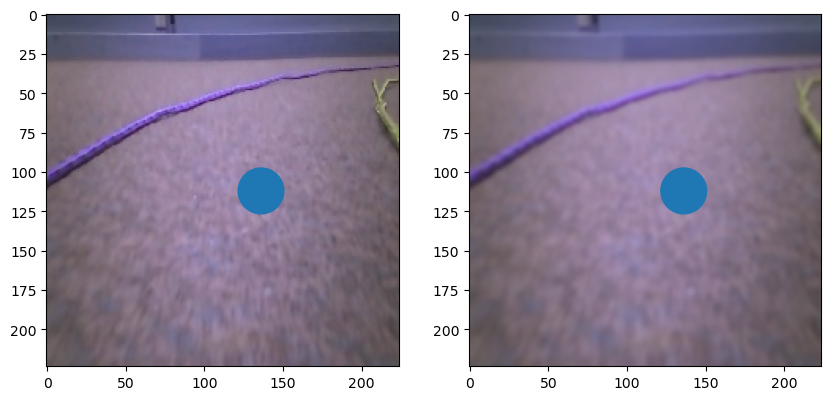

In [30]:
# Plotting an example of the data from the train loader

# Create a figure for both images
fig = plt.figure(figsize= (10, 10))

# Create a subplot for the array of images
ax = fig.add_subplot(1, 2, 1)

# Get an image, list of annotations and labels from the train dataloader
train_image, ann, train_labels = next(iter(train_dataloader))

# Getting the label for the image
x = train_labels[0].numpy()[0]
x = int(224 * (x / 2.0 + 0.5))

# Reading the raw image from file
file_path = ann['image_path'][0]
print(f"Selected File: {file_path}")
print(f"Label value (x): {x}")
img = cv2.imread(file_path)

# Plotting the raw image w/ label
circ = Circle((x,112),15)
ax.add_patch(circ)
ax.imshow(img)

# Getting the transformed image from the dataloader (all images on the
train_image = train_image.numpy()[0]
train_image = np.moveaxis(train_image, 0, -1)

# Plotting the transformed image w/ label
ax = fig.add_subplot(1, 2, 2)
circ = Circle((x,112),15)
ax.add_patch(circ)
ax.imshow(train_image)

## Training the CNN on the Selected Dataset
Next, we'll setup the training algorithm for our machine learning model.
As we prepare to train our model we need to make choices about the way we'll train it.
These choices can impact how long it takes to train the model and the overall accuracy of the model.

The user-set parameters of the training algorithm are often called "Hyper-Parameters"
You can set your hyper parameters below, make sure to track which setting you used for your training!

In [8]:
# Set Training Hyper Parameters:

########## [ACTION REQUIRED] Set name for new machine learning model #################
model_file_name = "UNM_Combined_wNormal" # Change this, leave the ""
training_notes = "This model was trained from all UNM datasets on April 26th, 2025." # leave the ""
# Example training notes: testing new dataset collected on Friday 1/10/25 at the library

# Number of training epochs: (25 to 35 is a great range to start with)
# epochs are training cycles
epochs = 25 # Hyperparameter (has a direct effect on the accuracy of the model)


#####################################################################################
model_folder = "/home/racer_core/Models/"
model_file_path = model_folder + model_file_name + ".pth"
training_chart_file_path = model_folder+model_file_name+".png"

# Model Name check
if os.path.isfile(model_file_path):
    raise Exception('Sorry, model with same name already exists, choose a different model file name.')

# Model Output
output_dim = 2
# Total number of epochs
total_epochs = epochs

######### Select a Machine learning model structure (Neural Network) ###########
######### Uncomment both the model and the fully connected layer "model.fc"

# Resnet 18
model_name = "Resnet 18"
model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Linear(512, output_dim)

# Resnet 34
#model_name = "Resnet 34"
#model = torchvision.models.resnet34(pretrained=True)
#model.fc = torch.nn.Linear(512, output_dim)

# Resnet 50
#model_name = "Resnet 50"
#model = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")
#model.fc = torch.nn.Linear(2048, output_dim)

# MobileNet V2
#model_name = "MobileNet_V2"
#model = torchvision.models.mobilenet_v2(pretrained=True)
#model.fc = torch.nn.Linear(2048, output_dim)

# MobileNet V3
#model_name = "MobileNet_V3"
#model = torchvision.models.mobilenet_v3_large(pretrained=True)
#model.classifier[-1] = torch.nn.Linear(1280, output_dim)

# ALEXNET
#model_name = "ALEXNET"
#model = torchvision.models.alexnet(pretrained=True)
#model.classifier[-1] = torch.nn.Linear(4096, output_dim)

# SQUEEZENET 
#model_name = "SQUEEZENET"
#model = torchvision.models.squeezenet1_1(pretrained=True)
#model.classifier[1] = torch.nn.Conv2d(512, output_dim, kernel_size=1)
#model.num_classes = len(dataset.categories)

# DENSENET 121
#model_name = "DENSENET_121"
#model = torchvision.models.densenet121(pretrained=True)
#model.classifier = torch.nn.Linear(model.num_features, output_dim)

# Save the model structure to use later during optimization
model_structure = model

# If you wanted to train fewer of the layers (freeze some layers) set
# Then we freeze the layers of the model
# TODO: Freeze all but final layer
freeze_layers = True

if freeze_layers == True:
    for param in model.parameters():
        param.requires_grad = True

# Adding a fully connected layer to the top/head of the model

# Model optimizer:
optimizer = torch.optim.Adam(model.parameters())

#Loading a GPU if available and otherwise a CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
def training_and_evaluation(epochs):
    # Setting up a simple user interface for the training process
    epoch_index_display = widgets.IntText(value=epochs, description='Epoch: ', disabled=False)
    epoch_progress_display = widgets.FloatProgress(value=0.0,max=len(datasets['train']) // BATCH_SIZE +1 , description='Epoch Progress:', bar_style='info', style={'bar_color': '#808080'}, orientation='horizontal')
    training_error_display = widgets.FloatText(value=0.0, description='Mean Square Error (MSE):', disabled=False) 
    progress_meter = widgets.FloatProgress(value=0.0, min=0, max=total_epochs, description='Progress:', bar_style='info', style={'bar_color': '#40E0D0'}, orientation='horizontal')
    system_status = widgets.Text(value='system_status', placeholder='system_status', description='Status:',disabled=False)
    epoch_display = widgets.HBox([epoch_index_display, epoch_progress_display])
    training_display = widgets.HBox([training_error_display, progress_meter])
    display(epoch_display)
    display(training_display)
    display(system_status)
    out1 = widgets.Output()

    display(widgets.HBox([out1]))


    # Training Timing
    start_time = datetime.now()

    # Writing training details to training log
    f = open("/home/racer_core/Models/training_log.txt", "a")
    f.write("\n")
    dt_string = start_time.strftime("%m/%d/%Y %H:%M:%S")
    f.write(f"Training Report: {dt_string} \n")
    f.write(f"Output Model File: {model_file_name}\n")
    f.write(f"Selected Dataset: {dataset_folder_name}, Number Data Points: {num_files}\n")
    f.write(f"Model: {model_name}, Epochs: {epochs}, Batch Size: {BATCH_SIZE}\n")
    f.write(f"Training Notes: {training_notes}\n")
    f.write(f"Transforms used in this training: {TRANSFORMS}\n")
    
    ############# Initiating Training Process ##############
    # First set model to train mode
    model.train()

    system_status.value = "Starting training process ..."
    
    # Start training process dependent on number of epochs
    while epochs > 0:
        system_status.value = "Training ..."
        # Index
        i = 0
        sum_loss = 0.0
        error_count = 0.0

        # Training Loop
        # Process each batch of data points in the train loader
        for images, category_idx, xy in iter(train_dataloader):
            i = i + 1

            # send data to device
            images = images.to(device)
            xy = xy.to(device)
            
            # zero gradients of parameters
            optimizer.zero_grad()
            
            # execute model to get outputs
            outputs = model(images)
            
            # run backpropogation to accumulate gradients
            loss = 0.0
            loss += torch.mean((outputs - xy)**2)
            loss.backward()
            
            # step optimizer to adjust parameters
            optimizer.step()

            # Update Epoch progress meter:
            epoch_progress_display.value = i
            
            # compute MSE loss over x, y coordinates for associated categories
            test = False
            if test == True:
                    
                xy = xy.cpu()
                outputs = outputs.detach().cpu().numpy().flatten()
                
                MSE = 0.0
                for j in range(len(xy)):
                  x = (224*(xy[j].numpy()[0]/2.0 + 0.5))
                  xi = (224*(outputs[j]/2.0 + 0.5))
                  MSE = MSE + (x-xi)**2
                
                MSE = MSE/len(xy)
                #training_error_display.value = MSE
    

        
        # Evaluation Loop
        system_status.value = "Evaluating ..."
        evaluation_loss = 0.0
        i = 0 
        for images, category_idx, xy in test_dataloader: # TODO: Make sure that xy is not a tensor
        
            # Put the model into evaluation mode
            model.eval()
        
            # send data to device
            images = images.to(device)
            xy = xy.to(device)
        
            # execute model to get outputs
            outputs = model(images)
        
            # compute MSE loss over x, y coordinates for associated categories
            outputs = model(images)
            
            #MSE = 0.0
            #for i in range(len(xy)):
            #    x = (224*(xy[i].numpy()[0]/2.0 + 0.5))
            #    xi = (224*(outputs[i]/2.0 + 0.5))
            #    MSE = MSE + (x-xi)**2

                        
            loss = 0.0
            loss += torch.mean((outputs - xy)**2)
            i += len(xy)
            evaluation_loss += float(loss)*1000

        
        #MSE = MSE/len(xy)
        #evaluation_loss = MSE
        print(f"Epoch: {epochs}, Evaluation Loss: {evaluation_loss/i}")
        training_error_display.value = evaluation_loss/i

        # Update Plot
        with out1:
            data['MSE'].append(evaluation_loss/i)
            live_plot(data, model_file_name=model_file_name, title='Model Error Chart: ' + model_file_name + ".pth")
            
        # End of the current epoch
        epochs = epochs -1
        epoch_index_display.value = epochs
        progress_meter.value = (total_epochs - epochs)

    
    # get the execution time
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    training_duration_time_formatted = str(elapsed_time)
    print('Execution time:', training_duration_time_formatted)
    
    # Finish writing to model training log
    f.write(f"Final model evaluation loss: {evaluation_loss/i}\n")
    f.write(f"Total training & evaluation time: {training_duration_time_formatted}\n")
    f.write("\n")
    f.close()
    system_status.value = "Training complete."   
    return model #trainLoss, validationLoss, model

# START TRAINING
model = training_and_evaluation(epochs)

# SAVE THE MODEL TO FILE
torch.save(model.state_dict(), model_file_path)
print(f"Saved new model as: {model_file_path}")

Text(value='system_status', description='Status:', placeholder='system_status')

Epoch: 25, Evaluation Loss: 0.0758852920260709
Epoch: 24, Evaluation Loss: 0.09794173939793707
Epoch: 23, Evaluation Loss: 0.16347073380158259
Epoch: 22, Evaluation Loss: 0.09878055352224788
Epoch: 21, Evaluation Loss: 0.07099568554509755
Epoch: 20, Evaluation Loss: 0.07248971653479488
Epoch: 19, Evaluation Loss: 0.07850144539844317
Epoch: 18, Evaluation Loss: 0.05927363267876474
Epoch: 17, Evaluation Loss: 0.06652399842508264
Epoch: 16, Evaluation Loss: 0.058176215181880236
Epoch: 15, Evaluation Loss: 0.06683279312073259
Epoch: 14, Evaluation Loss: 0.06610756633510934
Epoch: 13, Evaluation Loss: 0.052546720468122754
Epoch: 12, Evaluation Loss: 0.059282185576799235
Epoch: 11, Evaluation Loss: 0.05394084623207832
Epoch: 10, Evaluation Loss: 0.04890913455915711
Epoch: 9, Evaluation Loss: 0.05550969289498733
Epoch: 8, Evaluation Loss: 0.049404451409256145
Epoch: 7, Evaluation Loss: 0.06085779339150347
Epoch: 6, Evaluation Loss: 0.04370734810298683
Epoch: 5, Evaluation Loss: 0.046509626400

### Optimizing the Machine Learning Model to Run on the Robot
In this final step to the training process, we'll optimize the model.
We optimize the model so that it will run as fast as our camera collects data.


In [10]:
model_file_path = model_folder + model_file_name + ".pth"

# First Optimization Cell
# Warm starting the new model to be optimized - loading weights from trained model into untrained model
model = model_structure # this is the shape of the model before training
model = model.cuda().eval().half()
model.load_state_dict(torch.load(model_file_path, weights_only=True))

# When executed, we should see, "<All keys matched successfully>" 

<All keys matched successfully>

In [11]:
######## Optimization of the Network ############
### This step can take a few minutes or longer depending on the size of the mdoel

# Custom library from Nvidia to accelerate inference
from torch2trt import torch2trt

# Example structure of the input data
data = torch.zeros((1, 3, 224, 224)).cuda().half()

# Model optimization via quantitization, or the reduction of overall model size by reducing the representation of model weights.
model_trt = torch2trt(model, [data], fp16_mode=True)

# Saving our new optimized model to disk
optimized_model_folder = "/home/racer_core/Models/trt/"
optimized_model_file_path = optimized_model_folder + model_file_name + "_TRT.pth"
torch.save(model_trt.state_dict(), optimized_model_file_path)

# NOTES: If the kernel quits during optimization of the network
1. take note of the model name and structure (example: resnet 18)
2. Go to U2: Model Optimization notebook and select your model for optimization
3. Run all cells in U2: Model Optimization notebook.
4. If this process fails reboot computer and go directly to U2 notebook to try again.
